## Round 2 Assignment - Wallet Risk Scoring (From Compound V2)

**Objective:**  
Generate a risk score (0–1000) for each wallet based on its historical behavior on the Compound V2 protocol.

**Steps:**
1. Read 100 wallet addresses from Google Sheet  
2. Fetch transaction history for each wallet using Compound V2 Subgraph  
3. Engineer features: borrow amount, repay amount, collateral, debt, etc.  
4. Score wallets based on DeFi behavior (high borrow, low repay = risky)

**Deliverable:**  
CSV with columns: `wallet_id, score`  
Higher score = safer wallet  
Lower score = risky behavior (e.g., no repayment, high liquidation)


In [1]:
!pip install web3 pandas numpy requests pyarrow

import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from web3 import Web3



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.5/587.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.3 MB/s eta 0:00:00


In [2]:
def get_wallet_addresses():
    sheet_id = "1ZzaeMgNYnxvriYYpe8PE7uMEblTI0GV5GIVUnsP-sBs"
    sheet_name = "Sheet1"
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

    try:
        df = pd.read_csv(url)
        return df['wallet_id'].tolist()
    except Exception as e:
        print(f"Error loading wallet addresses: {e}")
        return []

wallet_addresses = get_wallet_addresses()


In [3]:
from web3 import Web3

# Setup with your NEW Alchemy API key
w3 = Web3(Web3.HTTPProvider("https://eth-mainnet.g.alchemy.com/v2/i_gTWpmMUobA07Hk7F_ym"))

# Minimal ABI for the one function we care about
COMPTROLLER_ABI = [{
    "constant": True,
    "inputs": [],
    "name": "getAllMarkets",
    "outputs": [{"name": "", "type": "address[]"}],
    "payable": False,
    "stateMutability": "view",
    "type": "function"
}]

# Comptroller contract address (Compound V2)
COMPTROLLER_ADDRESS = "0x3d9819210A31b4961b30EF54bE2aeD79B9c9Cd3B"

# Create contract instance
comptroller_contract = w3.eth.contract(address=COMPTROLLER_ADDRESS, abi=COMPTROLLER_ABI)

# Call the function to get all cToken addresses
def get_all_cTokens():
    try:
        ctoken_addresses = comptroller_contract.functions.getAllMarkets().call()
        return [addr.lower() for addr in ctoken_addresses] + [COMPTROLLER_ADDRESS.lower()]
    except Exception as e:
        print(f"Error fetching cTokens: {e}")
        return []

# Get them
compound_v2_contracts = set(get_all_cTokens())

# Print or use them
print("Total cTokens in Compound V2:", len(compound_v2_contracts))

Total cTokens in Compound V2: 21


In [4]:
compound_v2_contracts = [addr.lower() for addr in compound_v2_contracts]


In [5]:
# Function to get all transactions for a wallet using Alchemy's API
def get_transactions(wallet_address):
    # Your Alchemy API endpoint (you already have this)
    url = "https://eth-mainnet.g.alchemy.com/v2/i_gTWpmMUobA07Hk7F_ym"

    # Alchemy's asset transfer API payload
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "alchemy_getAssetTransfers",
        "params": [{
            "fromBlock": "0x0",  # Fetch from genesis block
            "toBlock": "latest",
            "fromAddress": wallet_address,
            "category": ["external", "internal", "erc20"],  # Fetch these categories only
            "excludeZeroValue": True  # Skip zero-value txs
        }]
    }

    headers = {"Content-Type": "application/json"}

    try:
        # Make POST request
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()

        # Parse and return transaction list
        data = response.json()
        return data.get("result", {}).get("transfers", [])

    except Exception as e:
        print(f"Error fetching transactions for {wallet_address}: {e}")
        return []


In [6]:
# Filters only transactions involving Compound V2 contracts
def filter_compound_v2_transactions(transactions):
    filtered = []

    for tx in transactions:
        to_addr = tx.get("to", "").lower()
        from_addr = tx.get("from", "").lower()
        contract_addr = tx.get("contractAddress", "").lower()

        # Check if any involved address matches a Compound V2 contract
        if to_addr in compound_v2_contracts or from_addr in compound_v2_contracts or contract_addr in compound_v2_contracts:
            filtered.append(tx)

    return filtered


In [7]:
# List to hold all processed wallet data
compound_data = []

# Loop through each wallet
for i, wallet in enumerate(wallet_addresses):
    print(f"Processing wallet {i+1}/{len(wallet_addresses)}: {wallet}")

    # Step 1: Fetch all transactions for this wallet
    all_tx = get_transactions(wallet)

    # Step 2: Filter only transactions related to Compound V2
    compound_tx = filter_compound_v2_transactions(all_tx)

    # Step 3: Store wallet info and filtered tx count
    compound_data.append({
        'wallet_id': wallet,
        'tx_count': len(compound_tx),
        'raw_transactions': compound_tx  # Keeping full data for later analysis
    })

    # Avoid hitting Alchemy rate limits
    time.sleep(0.3)


Processing wallet 1/103: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
Processing wallet 2/103: 0x06b51c6882b27cb05e712185531c1f74996dd988
Processing wallet 3/103: 0x0795732aacc448030ef374374eaae57d2965c16c
Processing wallet 4/103: 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
Processing wallet 5/103: 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Processing wallet 6/103: 0x104ae61d8d487ad689969a17807ddc338b445416
Processing wallet 7/103: 0x111c7208a7e2af345d36b6d4aace8740d61a3078
Processing wallet 8/103: 0x124853fecb522c57d9bd5c21231058696ca6d596
Processing wallet 9/103: 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
Processing wallet 10/103: 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
Processing wallet 11/103: 0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22
Processing wallet 12/103: 0x19df3e87f73c4aaf4809295561465b993e102668
Processing wallet 13/103: 0x1ab2ccad4fc97c9968ea87d4435326715be32872
Processing wallet 14/103: 0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f
Processing wallet 15/103: 0x1e43dacdcf86367

In [8]:
# Convert the results to DataFrame
raw_df = pd.DataFrame(compound_data)

# Save full data (including transaction details) for further processing
raw_df.to_pickle("compound_v2_raw_data.pkl")

# Save only summary (wallet_id + transaction count)
raw_df[['wallet_id', 'tx_count']].to_csv("compound_v2_tx_summary.csv", index=False)

print(" Raw and summary data saved.")


 Raw and summary data saved.


In [9]:
# Load the raw transaction data
raw_df = pd.read_pickle("compound_v2_raw_data.pkl")

# See the structure
print(f"Total wallets processed: {len(raw_df)}")
raw_df.head(10)


Total wallets processed: 103


,wallet_id,tx_count,raw_transactions
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0,[]
1,0x06b51c6882b27cb05e712185531c1f74996dd988,1,"[{'blockNum': '0xa8d14e', 'uniqueId': '0x25b33..."
2,0x0795732aacc448030ef374374eaae57d2965c16c,1,"[{'blockNum': '0xacd8d4', 'uniqueId': '0x22d03..."
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,1,"[{'blockNum': '0xae816c', 'uniqueId': '0xe74e6..."
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,1,"[{'blockNum': '0xa95e28', 'uniqueId': '0x936f7..."
5,0x104ae61d8d487ad689969a17807ddc338b445416,1,"[{'blockNum': '0xaee62c', 'uniqueId': '0x44347..."
6,0x111c7208a7e2af345d36b6d4aace8740d61a3078,1,"[{'blockNum': '0xaae2b8', 'uniqueId': '0x654be..."
7,0x124853fecb522c57d9bd5c21231058696ca6d596,3,"[{'blockNum': '0xab1fbc', 'uniqueId': '0xa90eb..."
8,0x13b1c8b0e696aff8b4fee742119b549b605f3cbc,1,"[{'blockNum': '0xaeb597', 'uniqueId': '0x398f8..."
9,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,39,"[{'blockNum': '0xb57895', 'uniqueId': '0xec304..."


In [10]:
# Filter wallets that have at least one transaction
non_empty_wallets = raw_df[raw_df["tx_count"] > 0]
print("Wallets with transactions:", len(non_empty_wallets))


Wallets with transactions: 102


In [11]:
# Pick the first wallet with tx > 0
sample_tx = non_empty_wallets.iloc[0]["raw_transactions"]

# Check structure
pd.DataFrame(sample_tx).head(5)


,blockNum,uniqueId,hash,from,to,value,erc721TokenId,erc1155Metadata,tokenId,asset,category,rawContract
0,0xa8d14e,0x25b33b7a990646ab6c0f22d2c4e91fe563bbd9b02e36...,0x25b33b7a990646ab6c0f22d2c4e91fe563bbd9b02e36...,0x06b51c6882b27cb05e712185531c1f74996dd988,0x39aa39c021dfbae8fac545936693ac917d5e7563,3,None,None,None,USDC,erc20,"{'value': '0x2dc6c0', 'address': '0xa0b86991c6..."


In [12]:
# Flatten all raw transactions into a single DataFrame with wallet_id
all_records = []

for _, row in raw_df.iterrows():
    wallet = row['wallet_id']
    transactions = row['raw_transactions']

    for tx in transactions:
        tx['wallet_id'] = wallet  # add wallet ID to each tx
        all_records.append(tx)

# Convert to DataFrame
flat_df = pd.DataFrame(all_records)

# See structure
print(f"Total transactions: {len(flat_df)}")
flat_df.head()


Total transactions: 432


,blockNum,uniqueId,hash,from,to,value,erc721TokenId,erc1155Metadata,tokenId,asset,category,rawContract,wallet_id
0,0xa8d14e,0x25b33b7a990646ab6c0f22d2c4e91fe563bbd9b02e36...,0x25b33b7a990646ab6c0f22d2c4e91fe563bbd9b02e36...,0x06b51c6882b27cb05e712185531c1f74996dd988,0x39aa39c021dfbae8fac545936693ac917d5e7563,3.0,None,None,None,USDC,erc20,"{'value': '0x2dc6c0', 'address': '0xa0b86991c6...",0x06b51c6882b27cb05e712185531c1f74996dd988
1,0xacd8d4,0x22d03ef2de5abcb5dd724279e59b050c995d6b6308ff...,0x22d03ef2de5abcb5dd724279e59b050c995d6b6308ff...,0x0795732aacc448030ef374374eaae57d2965c16c,0x39aa39c021dfbae8fac545936693ac917d5e7563,3.0,None,None,None,USDC,erc20,"{'value': '0x2dc6c0', 'address': '0xa0b86991c6...",0x0795732aacc448030ef374374eaae57d2965c16c
2,0xae816c,0xe74e61815250aae8a2cab45a4ab4a98bcda6a3832591...,0xe74e61815250aae8a2cab45a4ab4a98bcda6a3832591...,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,0x39aa39c021dfbae8fac545936693ac917d5e7563,3.0,None,None,None,USDC,erc20,"{'value': '0x2dc6c0', 'address': '0xa0b86991c6...",0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
3,0xa95e28,0x936f794a8eed05ee88765e3ddabb666473210fb18986...,0x936f794a8eed05ee88765e3ddabb666473210fb18986...,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,0x39aa39c021dfbae8fac545936693ac917d5e7563,3.0,None,None,None,USDC,erc20,"{'value': '0x2dc6c0', 'address': '0xa0b86991c6...",0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
4,0xaee62c,0x44347e686635e8ae9efa4b2ba9703144ca6fd40921c7...,0x44347e686635e8ae9efa4b2ba9703144ca6fd40921c7...,0x104ae61d8d487ad689969a17807ddc338b445416,0x39aa39c021dfbae8fac545936693ac917d5e7563,3.0,None,None,None,USDC,erc20,"{'value': '0x2dc6c0', 'address': '0xa0b86991c6...",0x104ae61d8d487ad689969a17807ddc338b445416


In [13]:
flat_df.shape

(432, 13)

In [14]:
flat_df.to_csv("compound_v2_all_transactions.csv", index=False)


In [15]:
# Drop unhashable/dict-like columns before checking for duplicates
safe_df = flat_df.drop(columns=['rawContract'], errors='ignore')

# Now check duplicates
duplicates = safe_df.duplicated()
print(f"Total duplicate rows: {duplicates.sum()}")


Total duplicate rows: 0


In [16]:
# Check missing values
missing_summary = flat_df.isnull().sum()
print("Missing values per column:\n", missing_summary)

# Optional: Percentage missing
print("\n% Missing:\n", (flat_df.isnull().mean() * 100).sort_values(ascending=False))


Missing values per column:
 blockNum             0
uniqueId             0
hash                 0
from                 0
to                   0
value                0
erc721TokenId      432
erc1155Metadata    432
tokenId            432
asset                0
category             0
rawContract          0
wallet_id            0
dtype: int64

% Missing:
 erc721TokenId      100.0
erc1155Metadata    100.0
tokenId            100.0
uniqueId             0.0
blockNum             0.0
to                   0.0
from                 0.0
hash                 0.0
value                0.0
asset                0.0
category             0.0
rawContract          0.0
wallet_id            0.0
dtype: float64


In [17]:
# Droping columns with 100% miising values
flat_df.drop(columns=['erc721TokenId', 'erc1155Metadata', 'tokenId'], inplace=True)


In [18]:
flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   blockNum     432 non-null    object 
 1   uniqueId     432 non-null    object 
 2   hash         432 non-null    object 
 3   from         432 non-null    object 
 4   to           432 non-null    object 
 5   value        432 non-null    float64
 6   asset        432 non-null    object 
 7   category     432 non-null    object 
 8   rawContract  432 non-null    object 
 9   wallet_id    432 non-null    object 
dtypes: float64(1), object(9)
memory usage: 33.9+ KB


### Data Cleaning Summary

- ✅ Loaded and flattened all raw transaction records.
- ✅ Identified and handled missing values:
  - Dropped NFT-related columns:
    - `erc721TokenId`, `erc1155Metadata`, `tokenId` (100% missing, not relevant for Compound V2)
- ✅ Verified no missing values remain in key columns:
  - `wallet_id`, `from`, `to`, `value`, `asset`, `category`, `blockNum`, `hash`


In [19]:
print(flat_df['category'].value_counts)

<bound method IndexOpsMixin.value_counts of 0         erc20
1         erc20
2         erc20
3         erc20
4         erc20
         ...   
427       erc20
428    internal
429    internal
430       erc20
431       erc20
Name: category, Length: 432, dtype: object>


In [20]:
# Add decimal adjustment (example for USDC)
flat_df['value_normalized'] = flat_df.apply(
    lambda x: int(x['rawContract']['value'], 16) / (10 ** 6)  # USDC=6 decimals
    if x['asset'] == 'USDC' else int(x['rawContract']['value'], 16) / (10 ** 18),
    axis=1
)

In [21]:
# Create helper tags from known logic
flat_df['from_lower'] = flat_df['from'].str.lower()
flat_df['to_lower'] = flat_df['to'].str.lower()
flat_df['wallet_lower'] = flat_df['wallet_id'].str.lower()

In [23]:
# Classify transactions
flat_df['is_supply'] = (flat_df['from_lower'] == flat_df['wallet_lower']) & \
                       (flat_df['to_lower'].isin(compound_v2_contracts)) & \
                       (flat_df['asset'] == 'USDC')  # Example for USDC

flat_df['is_borrow'] = (flat_df['to_lower'] == flat_df['wallet_lower']) & \
                       (flat_df['from_lower'].isin(compound_v2_contracts)) & \
                      (flat_df['asset'] == 'DAI')   # Example for DAI borrows

flat_df['is_repay'] = (flat_df['from_lower'] == flat_df['wallet_lower']) & \
                     (flat_df['to_lower'].isin(compound_v2_contracts)) & \
                     (flat_df['asset'] == 'DAI')




flat_df['is_withdraw'] = (flat_df['to_lower'] == flat_df['wallet_lower']) & \
                         (flat_df['from_lower'].isin(compound_v2_contracts)) & \
                         (flat_df['asset'] == 'USDC')

In [24]:
print(flat_df[flat_df['is_repay']][['asset', 'from', 'to', 'value']])


    asset                                        from  \
16    DAI  0x1656f1886c5ab634ac19568cd571bc72f385fdf7   
18    DAI  0x1656f1886c5ab634ac19568cd571bc72f385fdf7   
78    DAI  0x3361bea43c2f5f963f81ac70f64e6fba1f1d2a97   
106   DAI  0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65   
107   DAI  0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65   
..    ...                                         ...   
392   DAI  0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3   
420   DAI  0xf60304b534f74977e159b2e159e135475c245526   
421   DAI  0xf60304b534f74977e159b2e159e135475c245526   
423   DAI  0xf60304b534f74977e159b2e159e135475c245526   
425   DAI  0xf60304b534f74977e159b2e159e135475c245526   

                                             to         value  
16   0x5d3a536e4d6dbd6114cc1ead35777bab948e3643  10892.311400  
18   0x5d3a536e4d6dbd6114cc1ead35777bab948e3643    108.247970  
78   0x5d3a536e4d6dbd6114cc1ead35777bab948e3643   2500.000000  
106  0x5d3a536e4d6dbd6114cc1ead35777bab948e3643    150.0000

In [25]:
flat_df['is_liquidation_like'] = (
    (flat_df['from_lower'].isin(compound_v2_contracts) |
     flat_df['to_lower'].isin(compound_v2_contracts)) &
    ~(flat_df['is_supply'] | flat_df['is_borrow'] |
      flat_df['is_repay'] | flat_df['is_withdraw'])
)

In [26]:
wallet_features = flat_df.groupby('wallet_id').agg(
    total_supplied=('value_normalized', lambda x: x[flat_df.loc[x.index, 'is_supply']].sum()),
    total_borrowed=('value_normalized', lambda x: x[flat_df.loc[x.index, 'is_borrow']].sum()),
    total_repaid=('value_normalized', lambda x: x[flat_df.loc[x.index, 'is_repay']].sum()),
    total_withdrawn=('value_normalized', lambda x: x[flat_df.loc[x.index, 'is_withdraw']].sum()),
    tx_count=('hash', 'count'),
    active_assets=('asset', pd.Series.nunique)
).reset_index()

In [27]:
wallet_features.head()

,wallet_id,total_supplied,total_borrowed,total_repaid,total_withdrawn,tx_count,active_assets
0,0x06b51c6882b27cb05e712185531c1f74996dd988,3.0,0.0,0.0,0.0,1,1
1,0x0795732aacc448030ef374374eaae57d2965c16c,3.0,0.0,0.0,0.0,1,1
2,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,3.0,0.0,0.0,0.0,1,1
3,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,3.0,0.0,0.0,0.0,1,1
4,0x104ae61d8d487ad689969a17807ddc338b445416,3.0,0.0,0.0,0.0,1,1


Visualization and Distribution

In [29]:
wallet_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   wallet_id        102 non-null    object 
 1   total_supplied   102 non-null    float64
 2   total_borrowed   102 non-null    float64
 3   total_repaid     102 non-null    float64
 4   total_withdrawn  102 non-null    float64
 5   tx_count         102 non-null    int64  
 6   active_assets    102 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.7+ KB


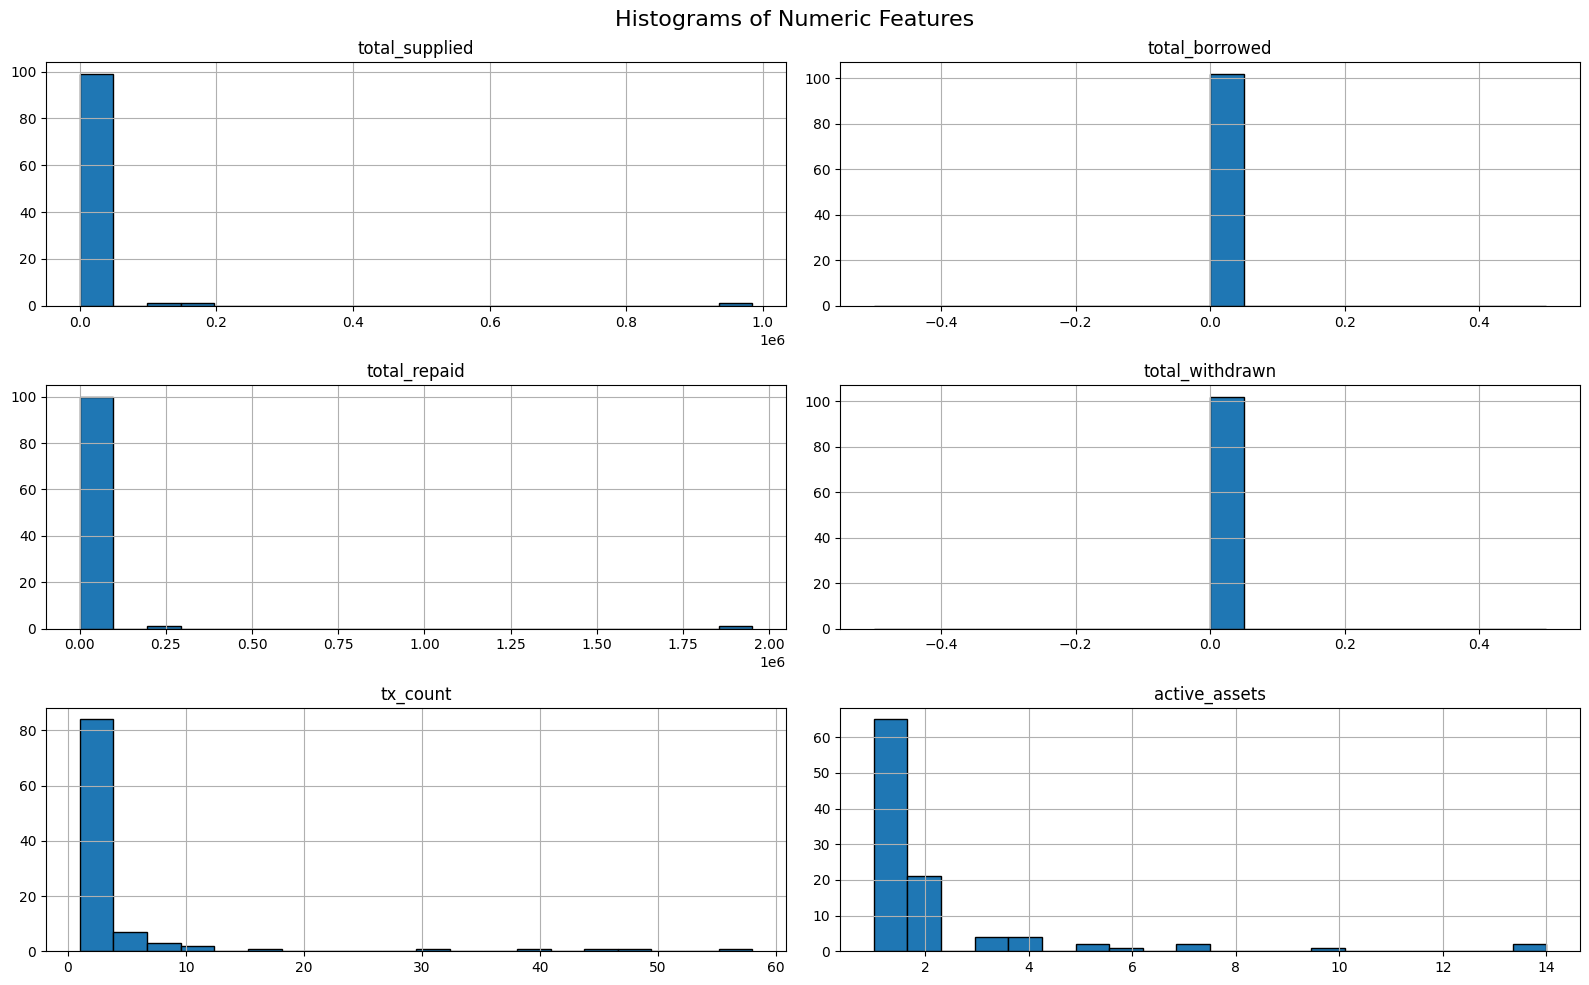

In [28]:
import matplotlib.pyplot as plt
wallet_features.drop(columns=['wallet_id']).hist(figsize=(16, 10), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()


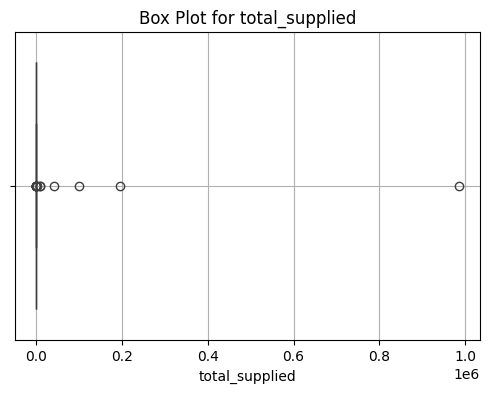

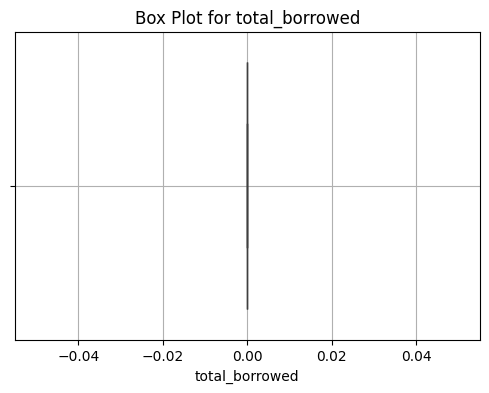

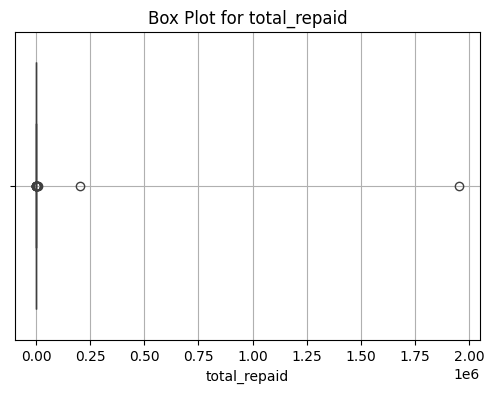

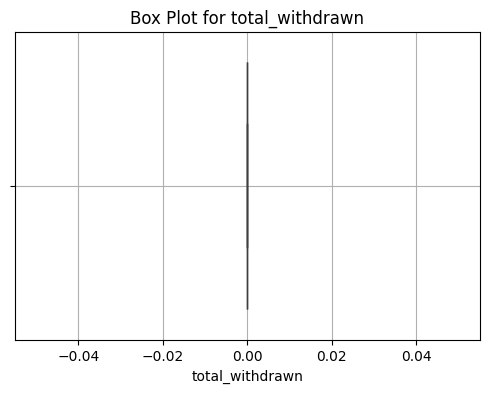

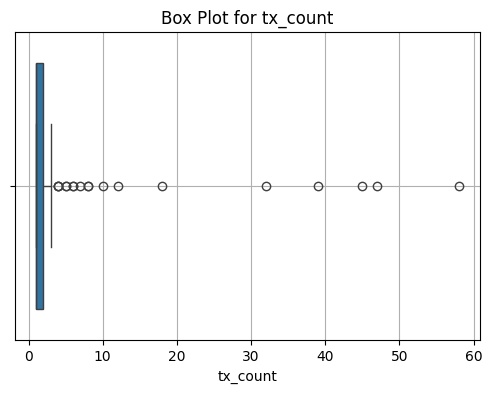

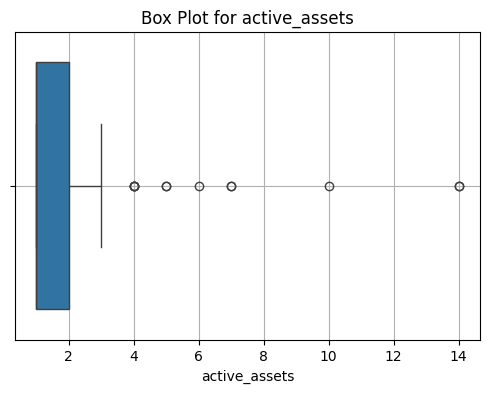

In [31]:
#  List of numeric columns
numeric_cols = ['total_supplied', 'total_borrowed', 'total_repaid', 'total_withdrawn', 'tx_count', 'active_assets']
import seaborn as sns

# Box plots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=wallet_features[col])
    plt.title(f"Box Plot for {col}")
    plt.grid(True)
    plt.show()

In [32]:
#  Detect and flag outliers using IQR method
outlier_summary = {}

for col in numeric_cols:
    Q1 = wallet_features[col].quantile(0.25)
    Q3 = wallet_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = wallet_features[(wallet_features[col] < lower) | (wallet_features[col] > upper)]
    outlier_summary[col] = {
        'count': len(outliers),
        'lower_bound': lower,
        'upper_bound': upper
    }

# 4. Print outlier counts
print("Outlier Summary:")
for col, summary in outlier_summary.items():
    print(f"{col}: {summary['count']} outliers (outside {summary['lower_bound']:.2f} to {summary['upper_bound']:.2f})")


Outlier Summary:
total_supplied: 15 outliers (outside -4.50 to 7.50)
total_borrowed: 0 outliers (outside 0.00 to 0.00)
total_repaid: 13 outliers (outside 0.00 to 0.00)
total_withdrawn: 0 outliers (outside 0.00 to 0.00)
tx_count: 18 outliers (outside -0.50 to 3.50)
active_assets: 12 outliers (outside -0.50 to 3.50)


In [34]:
# Cap outliers (Winsorizing)
df_capped = wallet_features.copy()
for col in numeric_cols:
    Q1 = wallet_features[col].quantile(0.25)
    Q3 = wallet_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_capped[col] = wallet_features[col].clip(lower=lower, upper=upper)

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assume your DataFrame is called `df`
# Backup original wallet IDs
wallet_ids = df_capped['wallet_id']

# 2. Drop wallet_id
X = df_capped.drop(columns=['wallet_id'])

# 3. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA - reduce to 1 feature
pca = PCA(n_components=1)
risk_score = pca.fit_transform(X_scaled)

from sklearn.preprocessing import MinMaxScaler

# Normalize the risk score to a 0–1000 scale
scaler = MinMaxScaler(feature_range=(0, 1000))
normalized_score = scaler.fit_transform(risk_score)


# 5. Combine wallet_id and risk score
result_df = pd.DataFrame({
    'wallet_id': wallet_ids,
    'risk_score': normalized_score.flatten()
})

# 6. Sort by risk score descending
result_df = result_df.sort_values(by='risk_score', ascending=False).reset_index(drop=True)

# 7. Display top N (say top 10 risky wallets)
print(result_df.head(10))


                                    wallet_id   risk_score
0  0x4839e666e2baf12a51bf004392b35972eeddeabf  1000.000000
1  0x1656f1886c5ab634ac19568cd571bc72f385fdf7  1000.000000
2  0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65  1000.000000
3  0x4814be124d7fe3b240eb46061f7ddfab468fe122  1000.000000
4  0x70d8e4ab175dfe0eab4e9a7f33e0a2d19f44001e  1000.000000
5  0x612a3500559be7be7703de6dc397afb541a16f7f  1000.000000
6  0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3  1000.000000
7  0x8be38ea2b22b706aef313c2de81f7d179024dd30  1000.000000
8  0xf340b9f2098f80b86fbc5ede586c319473aa11f3  1000.000000
9  0xbd4a00764217c13a246f86db58d74541a0c3972a   916.665984


In [37]:
# Save the final risk score results to CSV
result_df.to_csv("wallet_risk_scores.csv", index=False)
print("✅ Saved as wallet_risk_scores.csv")


✅ Saved as wallet_risk_scores.csv


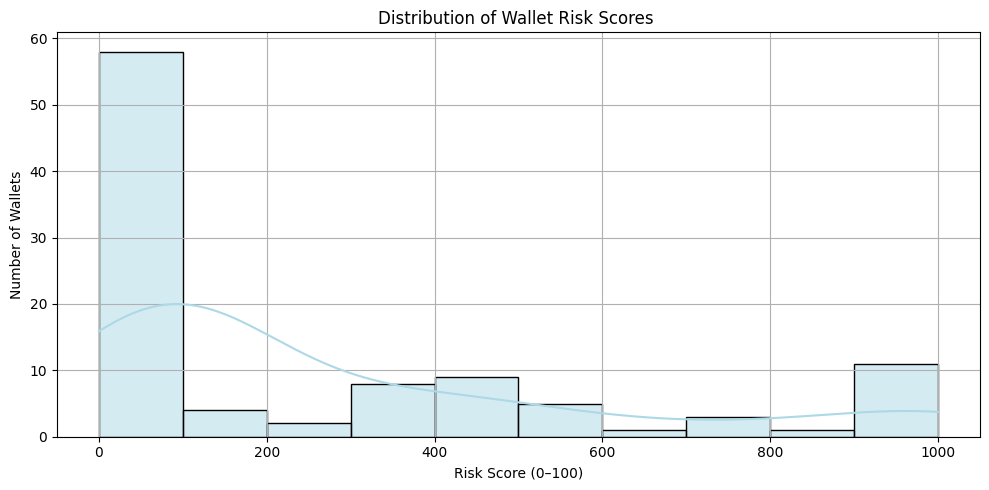

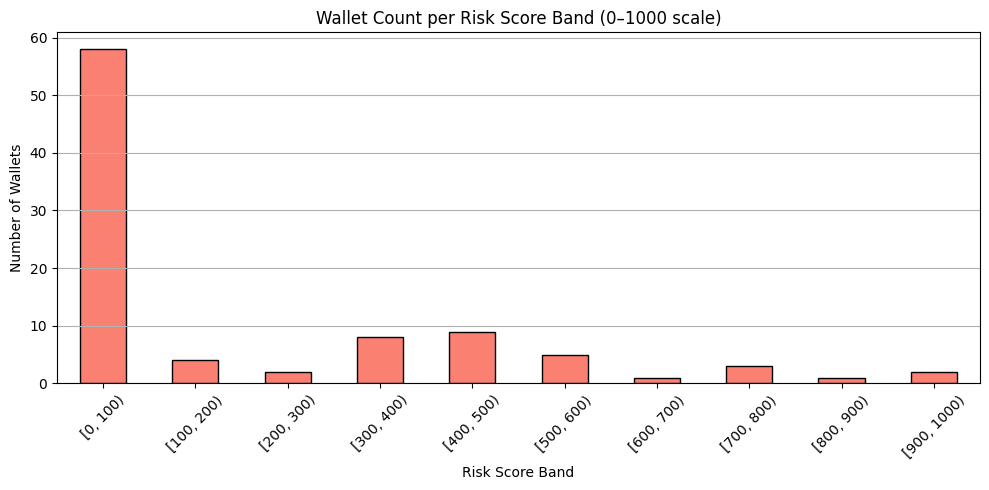

In [40]:
#  Convert score to 0–100 scale for easier interpretation

# Plot 1: Histogram (continuous distribution)
plt.figure(figsize=(10, 5))
sns.histplot(result_df['risk_score'], bins=10, kde=True, color='lightblue', edgecolor='black')
plt.title('Distribution of Wallet Risk Scores ')
plt.xlabel('Risk Score (0–100)')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Wallets per Risk Score Band (0–1000 scale)
result_df['risk_band'] = pd.cut(result_df['risk_score'], bins=range(0, 1100, 100), right=False)
band_counts = result_df['risk_band'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
band_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Wallet Count per Risk Score Band (0–1000 scale)')
plt.xlabel('Risk Score Band')
plt.ylabel('Number of Wallets')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Risk Score Interpretation

- **Risk Score Range:** 0 (Low Risk) to 1000 (High Risk)
- Most wallets have **borrow = 0** and **repay = 0**
- Hence, most scores are **near 0 → Low Risk**
- Few or no wallets show high borrow behavior → **High Risk (score near 1000)** is rare
